In [8]:
import numpy as np
import scipy.integrate as integrate
import time
from numba import njit


# Problem parameters (set defaults, override as needed)
epsilon = 1.0
c_a = 1.0
c_s = 1.0 - c_a
tau_0 = 10.0
x_0 = 0.5

# Radiation Energy Density
@njit
def fW(k, w, x, tau):
    P = (np.arctan(k + epsilon * w) + np.arctan(k - epsilon * w)) / (2 * k)
    Q = np.arctanh((2 * epsilon * k * w) / (1 + (epsilon * w)**2 + k**2)) / (2 * k)
    R = (c_a**2 + (c_s * w)**2) * (P**2 + Q**2) + 2 * (c_a**2) * w * Q - 2 * (c_a**2 + c_s * w**2) * P + w**2 + c_a**2
    Q_1 = 1 if x_0 == 0 else np.sin(k * x_0) / (k * x_0)
    h = Q_1 * ((c_a**2 + w**2) * P - (c_a**2 + c_s * w**2) * (P**2 + Q**2)) / R
    g = Q_1 * ((c_a**2 + w**2) * Q + (c_a**2) * w * (P**2 + Q**2)) / R

    if tau <= tau_0:
        return np.cos(k * x) * (h * np.sin(w * tau) + g * (1 - np.cos(w * tau))) / (w * np.pi**2)
    else:
        return np.cos(k * x) * (
            h * (np.sin(w * tau) - np.sin(w * (tau - tau_0))) +
            g * (np.cos(w * (tau - tau_0)) - np.cos(w * tau))
        ) / (w * np.pi**2)

# Material Energy Density
@njit
def fV(k, w, x, tau):
    P = (np.arctan(k + epsilon * w) + np.arctan(k - epsilon * w)) / (2 * k)
    Q = np.arctanh((2 * epsilon * k * w) / (1 + (epsilon * w)**2 + k**2)) / (2 * k)
    R = (c_a**2 + (c_s * w)**2) * (P**2 + Q**2) + 2 * (c_a**2) * w * Q - 2 * (c_a**2 + c_s * w**2) * P + w**2 + c_a**2
    Q_1 = 1 if x_0 == 0 else np.sin(k * x_0) / (k * x_0)
    h = Q_1 * ((c_a**2 + w**2) * P - (c_a**2 + c_s * w**2) * (P**2 + Q**2)) / R
    g = Q_1 * ((c_a**2 + w**2) * Q + (c_a**2) * w * (P**2 + Q**2)) / R

    if tau <= tau_0:
        return np.cos(k * x) * (
            (w * h + c_a * g) * np.sin(w * tau) +
            (c_a * h - w * g) * (np.cos(w * tau) - np.exp(-c_a * tau))
        ) / ((c_a**2 + w**2) * np.pi**2)
    else:
        return np.cos(k * x) * (
            (w * h + c_a * g) * (np.sin(w * tau) - np.sin(w * (tau - tau_0))) +
            (c_a * h - w * g) * (np.cos(w * tau) - np.cos(w * (tau - tau_0)) +
                                 np.exp(-c_a * (tau - tau_0)) - np.exp(-c_a * tau))
        ) / ((c_a**2 + w**2) * np.pi**2)

# Compute and save W and V
def run_custom_grid(x_values, tau_values, epsilon_in, c_a_in, x_0_in, tau_0_in, output_filename="benchmark_results.npz"):
    global epsilon, c_a, c_s, x_0, tau_0
    epsilon = epsilon_in
    c_a = c_a_in
    c_s = 1.0 - c_a
    x_0 = x_0_in
    tau_0 = tau_0_in

    W_array = np.zeros((len(x_values), len(tau_values)))
    V_array = np.zeros((len(x_values), len(tau_values)))


    print(f"Running benchmark for {len(x_values)} x-values and {len(tau_values)} tau-values...")
    tic = time.perf_counter()

    for i, x in enumerate(x_values):
        for j, tau in enumerate(tau_values):
            try:
                W = integrate.dblquad(lambda k, w: fW(k, w, x, tau), 0, np.inf, lambda k: 0, lambda k: np.inf)[0]
                V = W - integrate.dblquad(lambda k, w: fV(k, w, x, tau), 0, np.inf, lambda k: 0, lambda k: np.inf)[0]
                W_array[i, j] = W
                V_array[i, j] = V
            except ZeroDivisionError:
                print(f"Skipped (x={x:.4f}, tau={tau:.4f}) due to division by zero")
                W_array[i, j] = np.nan
                V_array[i, j] = np.nan
            print(f"W(x={x:.7f}, τ={tau:.5f}) = {W:.5f}, V = {V:.5f}")
    toc = time.perf_counter()
    print(f"Finished calculations in {toc - tic:.2f} seconds")

    np.savez(output_filename, x_values=x_values, tau_values=tau_values, W=W_array, V=V_array)
    print(f"Results saved to {output_filename}")

# ----------------------------------------------------------------------------------

# Define the spatial and time points where you want to evaluate W and V
# Define x_values as 
x_values = np.linspace(0.025, 5.00, 10)
#x_values = np.array([0.01, 0.1, 0.17783, 0.31623])
tau_values = np.linspace(0.01, 10.0, 10)
# tau_values = np.array([10.0])

# Parameters (can override the defaults)
epsilon = 1.0
c_a = 0.5
x_0 = 0.5
tau_0 = 10.0

# Run the benchmark calculation and save results
run_custom_grid(x_values, tau_values, epsilon, c_a, x_0, tau_0, output_filename="benchmark_results.npz")



Running benchmark for 10 x-values and 10 tau-values...


/Users/benjaminestrada/MonteCarloWithNoRandomNumbers/.venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/benjaminestrada/MonteCarloWithNoRandomNumbers/.venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/benjaminestrada/MonteCarloWithNoRandomNumbers/.venv/lib/python3.9/

W(x=0.0250000, τ=0.01000) = 0.00945, V = -0.00001
W(x=0.0250000, τ=1.12000) = 0.77442, V = 0.20710


/Users/benjaminestrada/MonteCarloWithNoRandomNumbers/.venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


W(x=0.0250000, τ=2.23000) = 1.08401, V = 0.52541
W(x=0.0250000, τ=3.34000) = 1.31628, V = 0.82323
W(x=0.0250000, τ=4.45000) = 1.51039, V = 1.07650
W(x=0.0250000, τ=5.56000) = 1.67849, V = 1.29572
W(x=0.0250000, τ=6.67000) = 1.82575, V = 1.49039
W(x=0.0250000, τ=7.78000) = 1.96918, V = 1.66497
W(x=0.0250000, τ=8.89000) = 2.10705, V = 1.83205
W(x=0.0250000, τ=10.00000) = 2.25592, V = 1.99500
W(x=0.5777778, τ=0.01000) = 0.00030, V = 0.00024
Skipped (x=0.5778, tau=1.1200) due to division by zero
W(x=0.5777778, τ=1.12000) = 0.00030, V = 0.00024
Skipped (x=0.5778, tau=2.2300) due to division by zero
W(x=0.5777778, τ=2.23000) = 0.55867, V = 0.00024
W(x=0.5777778, τ=3.34000) = 0.74513, V = 0.41699
W(x=0.5777778, τ=4.45000) = 0.90718, V = 0.59773
W(x=0.5777778, τ=5.56000) = 1.05169, V = 0.75760
Skipped (x=0.5778, tau=6.6700) due to division by zero
W(x=0.5777778, τ=6.67000) = 1.05169, V = 0.75760
Skipped (x=0.5778, tau=7.7800) due to division by zero
W(x=0.5777778, τ=7.78000) = 1.05169, V = 0.7

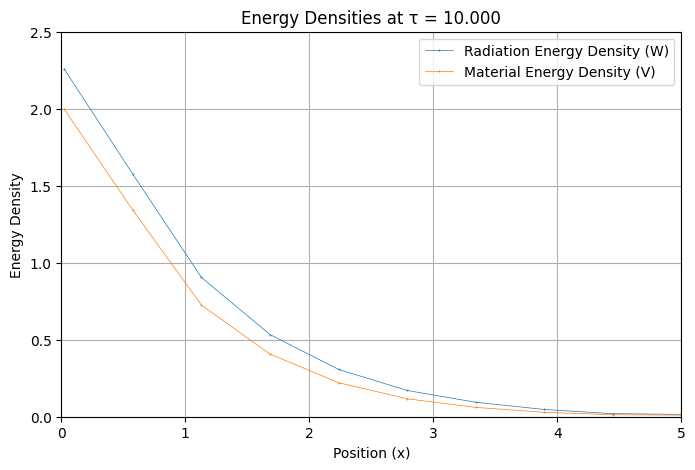

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data from the saved .npz file
data = np.load("benchmark_results.npz")
x_vals = data['x_values']
tau_vals = data['tau_values']
W = data['W']
V = data['V']

# Choose which tau index to plot (e.g., the middle time point)
tau_index = -1
tau = tau_vals[tau_index]

# Extract W and V for this tau over all x
W_at_tau = W[:, tau_index]
V_at_tau = V[:, tau_index]

# Plot
plt.figure(figsize=(8,5))
plt.plot(x_vals, W_at_tau, label='Radiation Energy Density (W)', marker='o', linewidth=0.5, markersize=0.4)
plt.plot(x_vals, V_at_tau, label='Material Energy Density (V)', marker='s', linewidth=0.5, markersize=0.4)

plt.xlabel('Position (x)')
plt.ylabel('Energy Density')
plt.xlim(0.0, 5.0)
plt.ylim(0.0, 2.5)
plt.title(f'Energy Densities at τ = {tau:.3f}')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
from scipy.integrate import dblquad
from numba import njit
import multiprocessing as mp

# ------------------------------
# Step 1: Numba-accelerated integrands
# ------------------------------

@njit
def fW_numba(k, w, x, tau):
    P = (np.arctan(k + epsilon * w) + np.arctan(k - epsilon * w)) / (2 * k)
    Q = np.arctanh((2 * epsilon * k * w) / (1 + (epsilon * w)**2 + k**2)) / (2 * k)
    R = (c_a**2 + (c_s * w)**2) * (P**2 + Q**2) + 2 * (c_a**2) * w * Q - 2 * (c_a**2 + c_s * w**2) * P + w**2 + c_a**2
    Q_1 = 1 if x_0 == 0 else np.sin(k * x_0) / (k * x_0)
    h = Q_1 * ((c_a**2 + w**2) * P - (c_a**2 + c_s * w**2) * (P**2 + Q**2)) / R
    g = Q_1 * ((c_a**2 + w**2) * Q + (c_a**2) * w * (P**2 + Q**2)) / R

    if tau <= tau_0:
        return np.cos(k * x) * (h * np.sin(w * tau) + g * (1 - np.cos(w * tau))) / (w * np.pi**2)
    else:
        return np.cos(k * x) * (
            h * (np.sin(w * tau) - np.sin(w * (tau - tau_0))) +
            g * (np.cos(w * (tau - tau_0)) - np.cos(w * tau))
        ) / (w * np.pi**2)

@njit
def fV_numba(k, w, x, tau):
    P = (np.arctan(k + epsilon * w) + np.arctan(k - epsilon * w)) / (2 * k)
    Q = np.arctanh((2 * epsilon * k * w) / (1 + (epsilon * w)**2 + k**2)) / (2 * k)
    R = (c_a**2 + (c_s * w)**2) * (P**2 + Q**2) + 2 * (c_a**2) * w * Q - 2 * (c_a**2 + c_s * w**2) * P + w**2 + c_a**2
    Q_1 = 1 if x_0 == 0 else np.sin(k * x_0) / (k * x_0)
    h = Q_1 * ((c_a**2 + w**2) * P - (c_a**2 + c_s * w**2) * (P**2 + Q**2)) / R
    g = Q_1 * ((c_a**2 + w**2) * Q + (c_a**2) * w * (P**2 + Q**2)) / R

    if tau <= tau_0:
        return np.cos(k * x) * (
            (w * h + c_a * g) * np.sin(w * tau) +
            (c_a * h - w * g) * (np.cos(w * tau) - np.exp(-c_a * tau))
        ) / ((c_a**2 + w**2) * np.pi**2)
    else:
        return np.cos(k * x) * (
            (w * h + c_a * g) * (np.sin(w * tau) - np.sin(w * (tau - tau_0))) +
            (c_a * h - w * g) * (np.cos(w * tau) - np.cos(w * (tau - tau_0)) +
                                 np.exp(-c_a * (tau - tau_0)) - np.exp(-c_a * tau))
        ) / ((c_a**2 + w**2) * np.pi**2)

# ------------------------------
# Step 2: Python wrappers for dblquad
# ------------------------------

def fW_wrapper(w, k, x, tau):
    return fW_numba(k, w, x, tau)

def fV_wrapper(w, k, x, tau):
    return fV_numba(k, w, x, tau)

# ------------------------------
# Step 3: Function to compute W and V
# ------------------------------

def compute_WV_dblquad(args):
    x, tau, k_min, k_max, w_min, w_max = args
    W, _ = dblquad(fW_wrapper, k_min, k_max, lambda k: w_min, lambda k: w_max, args=(x, tau))
    V_integral, _ = dblquad(fV_wrapper, k_min, k_max, lambda k: w_min, lambda k: w_max, args=(x, tau))
    V = W - V_integral
    return (x, tau, W, V)

# ------------------------------
# Step 4: Parallel driver
# ------------------------------

def run_parallel_dblquad(x_values, tau_values, k_min=1e-6, k_max=2.0, w_min=1e-6, w_max=2.0):
    tasks = [(x, tau, k_min, k_max, w_min, w_max) for x in x_values for tau in tau_values]

    with mp.Pool(processes=mp.cpu_count()) as pool:
        results = pool.map(compute_WV_dblquad, tasks)

    W_array = np.zeros((len(x_values), len(tau_values)))
    V_array = np.zeros((len(x_values), len(tau_values)))

    for x, tau, W, V in results:
        i = np.where(np.isclose(x_values, x))[0][0]
        j = np.where(np.isclose(tau_values, tau))[0][0]
        W_array[i, j] = W
        V_array[i, j] = V

    return W_array, V_array

# ------------------------------
# Step 5: Run and Save
# ------------------------------

if __name__ == "__main__":
    x_vals = np.linspace(0.01, 1.0, 5)
    tau_vals = np.linspace(0.01, 1.0, 5)

    print("Running parallel integration...")
    W, V = run_parallel_dblquad(x_vals, tau_vals)
    print("Done.")

    # Save to output file
    np.savez("WV_output.npz", x_vals=x_vals, tau_vals=tau_vals, W=W, V=V)
    print("Results saved to 'WV_output.npz'")


x_vals = [0.025      0.57777778 1.13055556 1.68333333 2.23611111 2.78888889
 3.34166667 3.89444444 4.44722222 5.        ]
tau values = [ 0.01  1.12  2.23  3.34  4.45  5.56  6.67  7.78  8.89 10.  ]


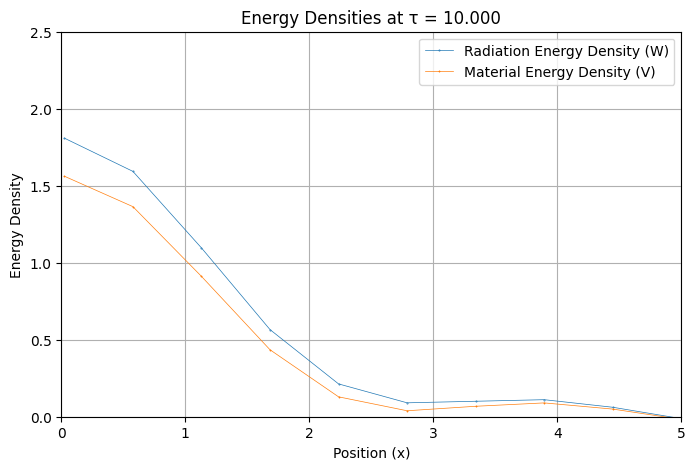

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data from the saved .npz file
data = np.load("WV_output.npz")
x_vals = data['x_vals']
print(f'x_vals = {x_vals}')
tau_vals = data['tau_vals']
print(f'tau values = {tau_vals}')
W = data['W']
V = data['V']

# Choose which tau index to plot (e.g., the middle time point or tau_index = 0)
tau_index = -1
tau = tau_vals[tau_index]

# Extract W and V for this tau over all x
W_at_tau = W[:, tau_index]
V_at_tau = V[:, tau_index]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x_vals, W_at_tau, label='Radiation Energy Density (W)', marker='o', linewidth=0.5, markersize=0.4)
plt.plot(x_vals, V_at_tau, label='Material Energy Density (V)', marker='s', linewidth=0.5, markersize=0.4)

plt.xlabel('Position (x)')
plt.ylabel('Energy Density')
plt.xlim(0.0, 5.0)
plt.ylim(0.0, 2.5)
plt.title(f'Energy Densities at τ = {tau:.3f}')
plt.legend()
plt.grid(True)
plt.show()
